# Deep Learning
# Laboratorio 6 - Recomenadaciones basadas en contenido

## Integrantes:
* Andres de la Roca
* Jun Woo Lee

Un sistema de recomendacion basado en contenido son principalmente utilizados para realizar recomendaciones en base a los datos encontrados en el dataset como tal y sin tratar de realizar operaciones que relacionan explícitamente una variable como el usuario con el libro directamente, sino que esta relación sea más implicita y que a partir de esto realice las predicciones necesarias para ofrecer una recomendación.


In [155]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from plotly.offline import init_notebook_mode
init_notebook_mode(connected=True)

In [156]:
df_ratings = pd.read_csv('./data/Ratings.csv')
df_users = pd.read_csv('./data/Users.csv')
df_books = pd.read_csv('./data/Books.csv')

C:\Users\Jun\AppData\Local\Temp\ipykernel_41276\3162812482.py:3: DtypeWarning:

Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.



In [157]:
df_ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1149780 entries, 0 to 1149779
Data columns (total 3 columns):
 #   Column       Non-Null Count    Dtype 
---  ------       --------------    ----- 
 0   User-ID      1149780 non-null  int64 
 1   ISBN         1149780 non-null  object
 2   Book-Rating  1149780 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 26.3+ MB


In [158]:
df_users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 278858 entries, 0 to 278857
Data columns (total 3 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   User-ID   278858 non-null  int64  
 1   Location  278858 non-null  object 
 2   Age       168096 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 6.4+ MB


In [159]:
df_books.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 271360 entries, 0 to 271359
Data columns (total 8 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   ISBN                 271360 non-null  object
 1   Book-Title           271360 non-null  object
 2   Book-Author          271359 non-null  object
 3   Year-Of-Publication  271360 non-null  object
 4   Publisher            271358 non-null  object
 5   Image-URL-S          271360 non-null  object
 6   Image-URL-M          271360 non-null  object
 7   Image-URL-L          271357 non-null  object
dtypes: object(8)
memory usage: 16.6+ MB


In [160]:
df_books = df_books[~df_books['Year-Of-Publication'].isin(['DK Publishing Inc', 'Gallimard'])]
df_books['Year-Of-Publication'] = pd.to_numeric(df_books['Year-Of-Publication'])

* Dataset Ratings:
  * User-ID: User ID
  * ISBN: ISBN number
  * Book-Rating: Rating of book given by user  


<br>

* Dataset Users:
  * User-ID: User ID
  * Location: Location of user
  * Age: Age of user  

<br>
  
  
* Dataset Books:
  * ISBN: ISBN number
  * Book-Title: Book title
  * Book-Author: Book author
  * Year-Of-Publication: Year of publication
  * Publisher: Publisher of book
  * Image-URL-S: URL of image cover small
  * Image-URL-M: URL of image cover medium
  * Image-URL-L: URL of image cover large

In [161]:
## EDA

In [162]:
def plot_distribution(data, title):
    sns.displot(data, kde=True, color='green')
    plt.title(title, fontfamily='serif', fontsize=20, fontweight='bold')

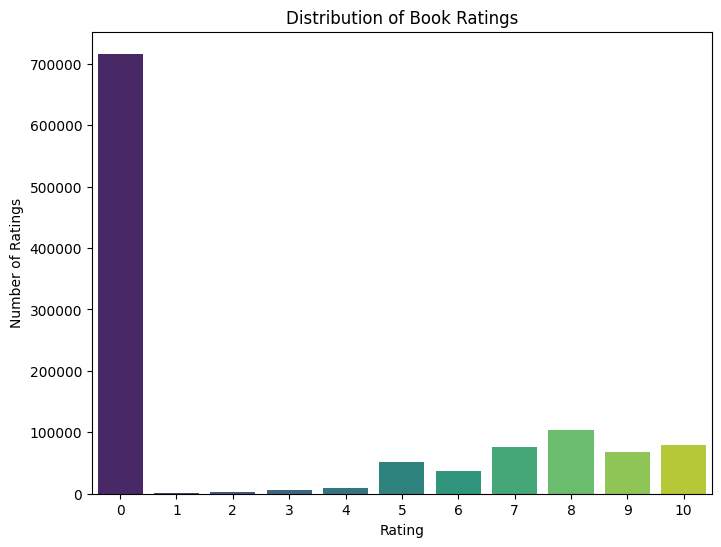

In [163]:
# Ratings distribution
plt.figure(figsize=(8, 6))
sns.countplot(x='Book-Rating', data=df_ratings, palette='viridis')
plt.title('Distribution of Book Ratings')
plt.xlabel('Rating')
plt.ylabel('Number of Ratings')
plt.show()






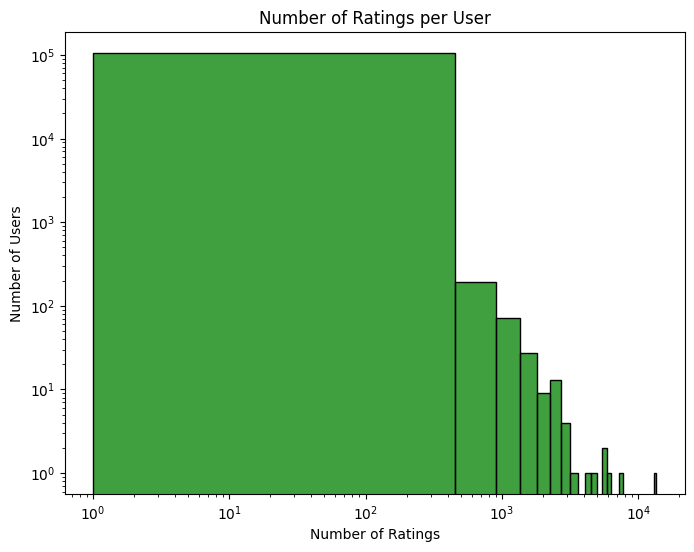

In [164]:
# Number of ratings per user
ratings_per_user = df_ratings['User-ID'].value_counts()
plt.figure(figsize=(8, 6))
sns.histplot(ratings_per_user, bins=30, kde=False, color='green')
plt.title('Number of Ratings per User')
plt.xlabel('Number of Ratings')
plt.ylabel('Number of Users')
plt.xscale('log')
plt.yscale('log')
plt.show()


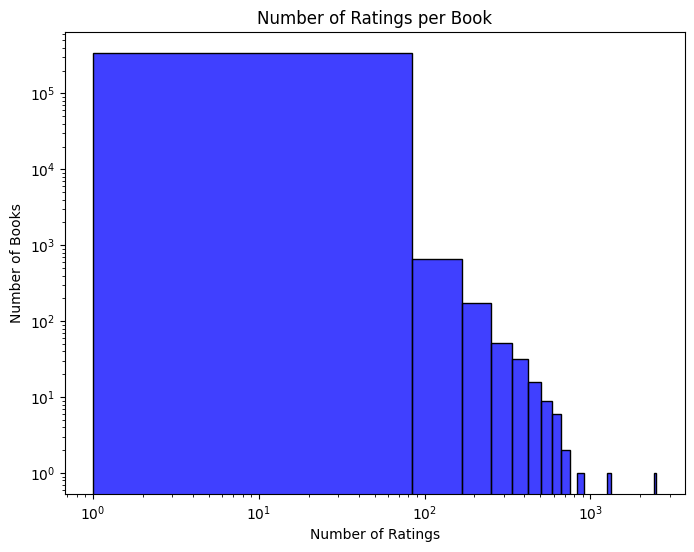

In [165]:
# Number of ratings per book
ratings_per_book = df_ratings['ISBN'].value_counts()
plt.figure(figsize=(8, 6))
sns.histplot(ratings_per_book, bins=30, kde=False, color='blue')
plt.title('Number of Ratings per Book')
plt.xlabel('Number of Ratings')
plt.ylabel('Number of Books')
plt.xscale('log')
plt.yscale('log')
plt.show()

In [166]:
# Calculate matrix sparsity
num_users = df_users['User-ID'].nunique()
num_books = df_books['ISBN'].nunique()
matrix_size = num_users * num_books
num_ratings = df_ratings.shape[0]
sparsity = 1 - (num_ratings / matrix_size)
print(f'Matrix Sparsity: {sparsity:.4f}')

Matrix Sparsity: 1.0000


## Preprocesamiento

In [167]:
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import pandas as pd

In [168]:
df_merging = df_ratings.merge(df_users, on='User-ID', how='left').merge(df_books, on='ISBN', how='left')

In [169]:
user_ids = df_merging['User-ID'].astype('category').cat.codes
book_ids = df_merging['ISBN'].astype('category').cat.codes

# Replace the 'User-ID' and 'ISBN' with their encoded versions
df_merging['User-ID'] = user_ids
df_merging['ISBN'] = book_ids


In [170]:
impute_median = SimpleImputer(strategy='median')
df_merging['Age'] = impute_median.fit_transform(df_merging[['Age']])


In [171]:
ratings_scaler = MinMaxScaler()
df_merging['Book-Rating'] = ratings_scaler.fit_transform(df_merging[['Book-Rating']])


In [172]:
train_data, test_data = train_test_split(df_merging, test_size=0.2, random_state=42)


In [173]:
X_train = [train_data['User-ID'].values, train_data['ISBN'].values]
y_train = train_data['Book-Rating'].values

X_test = [test_data['User-ID'].values, test_data['ISBN'].values]
y_test = test_data['Book-Rating'].values


## Modelo

In [174]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, Flatten, Dot, Dense, Concatenate
from tensorflow.keras.optimizers import Adam
import joblib

In [175]:
# After preprocessing and before splitting the data into train and test
num_users = df_merging['User-ID'].nunique()
num_books = df_merging['ISBN'].nunique()

# This assumes that df_merging has 'User-ID' and 'ISBN' columns with categorical data already converted to codes


# If you haven't converted 'User-ID' and 'ISBN' to codes, do it now
user_ids = df_merging['User-ID'].astype('category').cat.codes
book_ids = df_merging['ISBN'].astype('category').cat.codes

# Replace the 'User-ID' and 'ISBN' with their encoded versions
df_merging['User-ID'] = user_ids
df_merging['ISBN'] = book_ids

In [176]:
# Define the size of the embeddings
embedding_size = 15

# User Embedding Path
user_id_input = Input(shape=(1,), name='user_id_input')
user_embedding = Embedding(input_dim=num_users + 1, output_dim=embedding_size, name='user_embedding')(user_id_input)
user_vec = Flatten(name='flatten_user')(user_embedding)

# Book Embedding Path
book_id_input = Input(shape=(1,), name='book_id_input')
book_embedding = Embedding(input_dim=num_books + 1, output_dim=embedding_size, name='book_embedding')(book_id_input)
book_vec = Flatten(name='flatten_book')(book_embedding)

In [177]:
# Dot Product of Book and User Embeddings
product = Dot(name='dot_product', axes=1)([book_vec, user_vec])

In [182]:
# Add fully connected layers
fc1 = Dense(128, activation='relu')(product)
fc2 = Dense(1, activation='sigmoid')(fc1)  # Changed to sigmoid for outputs between 0 and 1

model = Model(inputs=[user_id_input, book_id_input], outputs=fc2)
model.compile(optimizer=Adam(0.001), loss='mean_squared_error')

In [183]:
# Split the data
train_data, test_data = train_test_split(df_merging, test_size=0.2, random_state=42)

# Prepare the inputs
X_train = [train_data['User-ID'].values, train_data['ISBN'].values]
y_train = train_data['Book-Rating'].values
X_test = [test_data['User-ID'].values, test_data['ISBN'].values]
y_test = test_data['Book-Rating'].values

# Fit the model using the training data
model.fit(X_train, y_train, epochs=5, batch_size=64, validation_split=0.2)


Epoch 1/5
11498/11498 [==============================] - 485s 42ms/step - loss: 0.1462 - val_loss: 0.1405
Epoch 2/5
11498/11498 [==============================] - 485s 42ms/step - loss: 0.0644 - val_loss: 0.1776
Epoch 3/5
11498/11498 [==============================] - 486s 42ms/step - loss: 0.0337 - val_loss: 0.1773
Epoch 4/5
11498/11498 [==============================] - 487s 42ms/step - loss: 0.0237 - val_loss: 0.1812
Epoch 5/5
11498/11498 [==============================] - 479s 42ms/step - loss: 0.0185 - val_loss: 0.1946


## Obteniendo recomendaciones

In [184]:
# Create a mapping from encoded book IDs to book titles
book_id_to_title_map = pd.Series(df_books['Book-Title'].values, index=df_books.index).to_dict()

# Assume new_user_id is the new user's ID and is within the correct range
new_user_id = num_users  # This assumes that you're incrementing the last known user ID

# Create an array of book IDs (encoded as in the training data)
all_book_ids = np.arange(num_books)

# Create an array for the user ID that matches the length of book IDs
new_user_array = np.full_like(all_book_ids, fill_value=new_user_id)

# Predict ratings for all user-item pairs
new_user_predictions = model.predict([new_user_array, all_book_ids])

# Inverse transform the ratings if they were normalized
# Assuming 'ratings_scaler' was fit on the original ratings data
new_user_predictions = ratings_scaler.inverse_transform(new_user_predictions)

# Combine predictions with book IDs
book_ratings = pd.DataFrame({
    'ISBN': all_book_ids,
    'Rating': new_user_predictions.flatten()
})

# Sort the books by predicted ratings in descending order
recommended_books = book_ratings.sort_values(by='Rating', ascending=False)

# Retrieve the top N recommendations
top_n_books = recommended_books.head(10)

# Use the mapping to get the book titles for the top recommended books
top_n_books = recommended_books.head(10)
top_n_books['Book-Title'] = top_n_books['ISBN'].apply(lambda x: book_id_to_title_map.get(x, "Unknown"))

# Display the top N recommendations
print(top_n_books[['Book-Title', 'Rating']])


10643/10643 [==============================] - 6s 521us/step
                                               Book-Title    Rating
81864                                           Shameless  7.086408
87591   The Pleiadian Agenda: A New Cosmology for the ...  7.057976
113663  Introduction to Database Systems (Systems Prog...  6.971127
221284  The Bread of Those Early Years (European Class...  6.968082
103494  Khrushchev and the First Russian Spring: The E...  6.924731
256993      Canada, cancelled because of lack of interest  6.849044
9913    Call Me Crazy : A Memoir (Lisa Drew Books (Har...  6.811523
27725                                              Hunger  6.808276
108215                        Too Many Babas (I Can Read)  6.775596
149346   The Canoe Trip Mystery #40 (The Boxcar Children)  6.769440


C:\Users\Jun\AppData\Local\Temp\ipykernel_41276\3298128328.py:34: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

